# 导入必要的库

我们需要导入一个叫 [captcha](https://github.com/lepture/captcha/) 的库来生成验证码。

我们生成验证码的字符由数字和大写字母组成。

In [13]:
#from captcha.image import ImageCaptcha
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import string
characters = string.digits  + string.ascii_uppercase + string.ascii_lowercase
pred_characters = string.digits  + string.ascii_uppercase
print(characters)

width, height, n_len, n_class = 120, 36, 4, len(pred_characters)+1

0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


# 定义 CTC Loss

In [14]:
from keras import backend as K

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

# 定义网络结构

In [15]:
from keras.models import *
from keras.layers import *
#from keras.engine.topology import Merge
rnn_size = 128

input_tensor = Input((width, height, 3))
x = input_tensor
for i in range(3):
    x = Conv2D(32, (3, 3), activation='relu', data_format='channels_last')(x)
    x = Conv2D(32, (3, 3), activation='relu', data_format='channels_last')(x)
    x = MaxPooling2D(pool_size=(2, 2), data_format='channels_last')(x)

conv_shape = x.get_shape()
x = Reshape(target_shape=(int(conv_shape[1]), int(conv_shape[2]*conv_shape[3])))(x)

x = Dense(32, activation='relu')(x)

gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(x)
gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(x)
gru1_merged =  Add()([gru_1, gru_1b])

gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)
x = Concatenate()([gru_2, gru_2b] )
x = Dropout(0.25)(x)
x = Dense(n_class, kernel_initializer='he_normal', activation='softmax')(x)
base_model = Model(inputs=input_tensor, outputs=x)

labels = Input(name='the_labels', shape=[n_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')
loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([x, labels, input_length, label_length])

model = Model(inputs=[input_tensor, labels, input_length, label_length], outputs=[loss_out])
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adadelta')

# 网络结构可视化

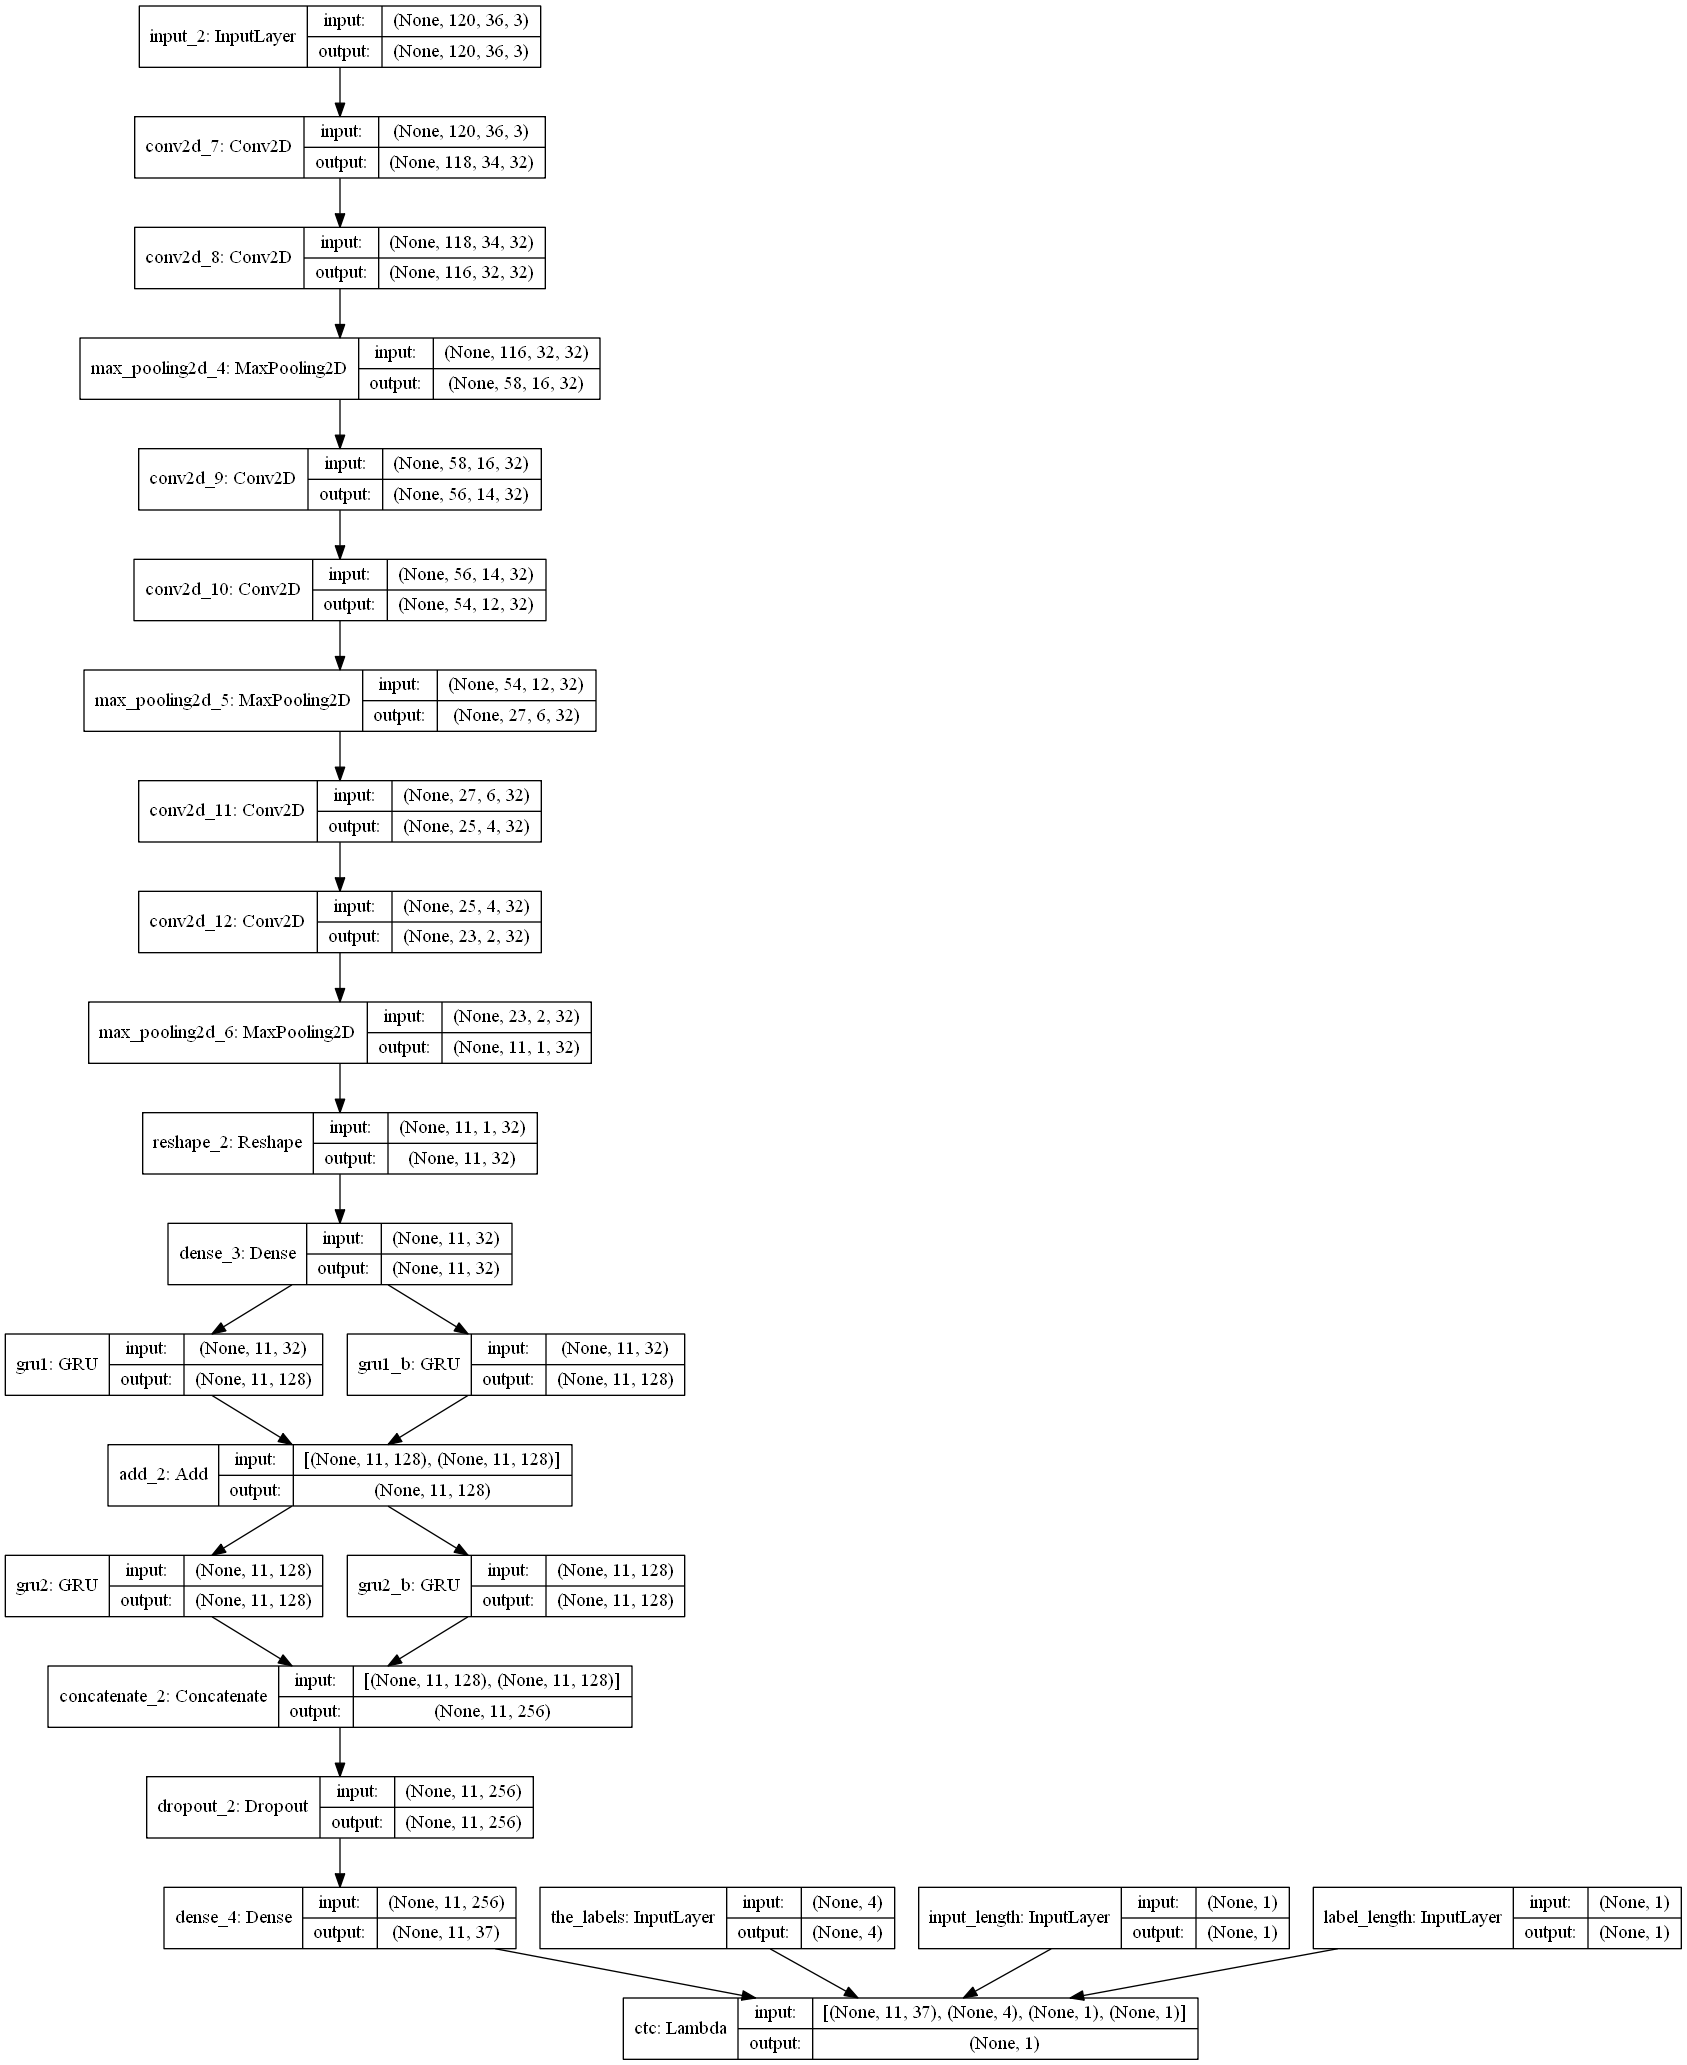

In [16]:
from IPython.display import SVG, Image
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="model.png", show_shapes=True)
Image('model.png')
# SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# 导入权值

这是之前跑好了的模型

In [3]:
# model.load_weights('model.h5')

# 定义数据生成器

In [17]:
def gen(batch_size=128):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    while True:
        #generator = ImageCaptcha(width=width, height=height, fonts=('c:/Windows/Fonts/arial.ttf',), font_sizes=(30,))
        generator = ImageCaptcha(width=width, height=height, fonts=('c:\\Windows\\Fonts\\arial.ttf',), font_sizes=(26,30,34))
        for i in range(batch_size):
            random_str = ''.join([random.choice(characters) for j in range(4)])
            show_str=''.join([" " for j in range(random.randint(0,5))])+random_str
            #generator
            img = generator.generate_image(show_str )
            #print(img)
            X[i] = np.array(img).transpose(1, 0, 2)
            pred_str = random_str.upper()
            y[i] = [characters.find(x) for x in pred_str]
        yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), np.ones(batch_size)*n_len], np.ones(batch_size)

Text(0.5,1,'BER8')

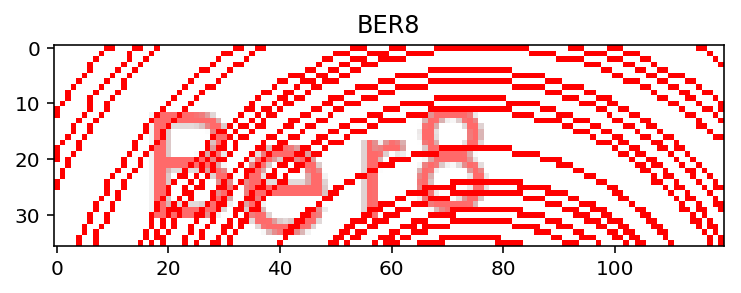

In [22]:
g=gen(1)
[X_test, y_test, _, _], _  = next(g)
#print(X_test[0].sharp)
plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title(''.join([characters[x] for x in y_test[0]]))

# 测试生成器

In [59]:
from keras.utils.np_utils import to_categorical
from PIL import Image as pilImage
import os
def gen(batch_size=32):
    X = np.zeros((batch_size, width, height, 3), dtype=np.uint8)
    y = np.zeros((batch_size, n_len), dtype=np.uint8)
    counter = 0
    while True: 
        list_dirs = os.walk("../get_image/img") 
        for root, dirs, files in list_dirs: 
            for f in files: 
                file = os.path.join(root, f) 
#                 if len(f) != 8:
#                     print("<", f,">")
                img=pilImage.open(file)
                print(img)
                #print(img,np.array(img).shape)
                X[counter] = np.array(img).transpose(1, 0 , 2)
                y[counter]= [characters.find(x) for x in f[0:4]]
                counter += 1
                if counter == batch_size:
                    yield [X, y, np.ones(batch_size)*int(conv_shape[1]-2), np.ones(batch_size)*n_len], np.ones(batch_size)
                    #print('counter=%d',counter)
                    counter = 0


<PIL.Image.Image image mode=RGB size=120x36 at 0x21B6DC00550>


Text(0.5,1,'x9LQ')

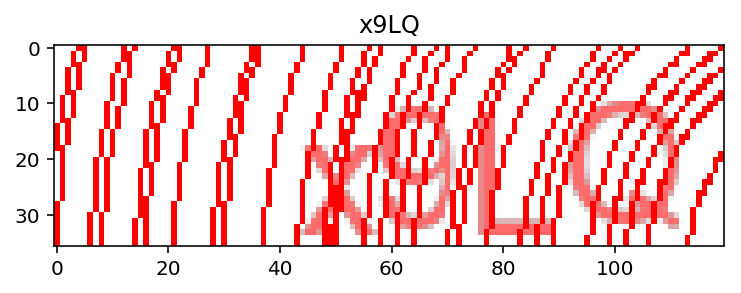

In [82]:
g=gen(1)
[X_test, y_test, _, _], _  = next(g)
plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title(''.join([characters[x] for x in y_test[0]]))

# 训练模型

In [23]:
def evaluate(model, batch_num=10):
    batch_acc = 0
    generator = gen(128)
    for i in range(batch_num):
        [X_test, y_test, _, _], _  = next(generator)
        y_pred = base_model.predict(X_test)
        shape = y_pred[:,2:,:].shape
        out = K.get_value(K.ctc_decode(y_pred[:,2:,:], input_length=np.ones(shape[0])*shape[1])[0][0])[:, :4]
        if out.shape[1] == 4:
            batch_acc += ((y_test == out).sum(axis=1) == 4).mean()
    return batch_acc / batch_num

In [24]:
from keras.callbacks import *

class Evaluate(Callback):
    def __init__(self):
        self.accs = []
    
    def on_epoch_end(self, epoch, logs=None):
        acc = evaluate(base_model)*100
        self.accs.append(acc)
        print
        print ('acc: %f%%'%acc)

evaluator = Evaluate()

In [ ]:
model.fit_generator(gen(128), steps_per_epoch=400, epochs =10,
                    callbacks=[EarlyStopping(patience=10), evaluator],
                    validation_data=gen(), validation_steps=10)

Epoch 1/10
400/400 [==============================] - 912s 2s/step - loss: 15.5194 - val_loss: 15.4957
acc: 0.000000%
Epoch 2/10
400/400 [==============================] - 1006s 3s/step - loss: 15.4887 - val_loss: 15.4045
acc: 0.000000%
Epoch 3/10
400/400 [==============================] - 914s 2s/step - loss: 15.4532 - val_loss: 15.3738
acc: 0.000000%
Epoch 4/10
400/400 [==============================] - 1012s 3s/step - loss: 15.4062 - val_loss: 15.5708
acc: 0.000000%
Epoch 5/10
400/400 [==============================] - 872s 2s/step - loss: 15.2572 - val_loss: 14.8817
acc: 0.000000%
Epoch 6/10
 13/400 [..............................] - ETA: 15:54 - loss: 14.9007

In [ ]:
model.fit_generator(gen(128), samples_per_epoch=51200, nb_epoch=200,
                    callbacks=[EarlyStopping(patience=10), evaluator],
                    validation_data=gen(), nb_val_samples=1280)

# 测试模型

[(36, 'a'),
 (36, 'a'),
 (36, 'a'),
 (25, 'P'),
 (62, ' '),
 (62, ' '),
 (62, ' '),
 (62, ' '),
 (62, ' ')]

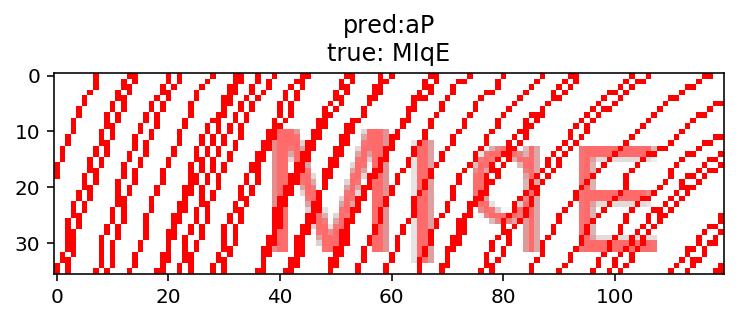

In [11]:
characters2 = characters + ' '
[X_test, y_test, _, _], _  = next(gen(1))
y_pred = base_model.predict(X_test)
y_pred = y_pred[:,2:,:]
out = K.get_value(K.ctc_decode(y_pred, input_length=np.ones(y_pred.shape[0])*y_pred.shape[1], )[0][0])[:, :4]
out = ''.join([characters[x] for x in out[0]])
y_true = ''.join([characters[x] for x in y_test[0]])

plt.imshow(X_test[0].transpose(1, 0, 2))
plt.title('pred:' + str(out) + '\ntrue: ' + str(y_true))

argmax = np.argmax(y_pred, axis=2)[0]
list(zip(argmax, ''.join([characters2[x] for x in argmax])))

# 计算模型总体准确率

In [44]:
evaluate(base_model)

0.0

In [16]:
model.save('model.h5')

In [1]:
from keras.models import load_model
 
model = load_model('model.h5')

d:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
d:\Anaconda3\lib\site-packages\keras\engine\base_layer.py:1124: UserWarning: Update your `InputLayer` call to the Keras 2 API: `InputLayer(batch_input_shape=[None, 170..., sparse=False, name="input_1", dtype="float32")`
  return cls(**config)
d:\Anaconda3\lib\site-packages\keras\engine\base_layer.py:1124: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(trainable=True, name="convolution2d_1", activity_regularizer=None, activation="relu", kernel_size=(3, 3), filters=32, strides=[1, 1], padding="valid", data_format="channels_last", kernel_initializer="glorot_uniform", kernel_regularizer=None, bias_regularizer=None, kernel_constraint=None, bias_constraint

ValueError: Unknown layer: Merge

In [19]:
# coding: utf-8
"""
    captcha.image
    ~~~~~~~~~~~~~

    Generate Image CAPTCHAs, just the normal image CAPTCHAs you are using.
"""

import os
import random
from PIL import Image
from PIL import ImageFilter
from PIL.ImageDraw import Draw
from PIL.ImageFont import truetype
try:
    from cStringIO import StringIO as BytesIO
except ImportError:
    from io import BytesIO
try:
    from wheezy.captcha import image as wheezy_captcha
except ImportError:
    wheezy_captcha = None

DATA_DIR = os.path.join(os.path.abspath('./'), 'data')
DEFAULT_FONTS = [os.path.join(DATA_DIR, 'c:\Windows\Fonts\arial.ttf')]

if wheezy_captcha:
    __all__ = ['ImageCaptcha', 'WheezyCaptcha']
else:
    __all__ = ['ImageCaptcha']


table  =  []
for  i  in  range( 256 ):
    table.append( i * 1.97 )


class _Captcha(object):
    def generate(self, chars, format='png'):
        """Generate an Image Captcha of the given characters.

        :param chars: text to be generated.
        :param format: image file format
        """
        im = self.generate_image(chars)
        out = BytesIO()
        im.save(out, format=format)
        out.seek(0)
        return out

    def write(self, chars, output, format='png'):
        """Generate and write an image CAPTCHA data to the output.

        :param chars: text to be generated.
        :param output: output destionation.
        :param format: image file format
        """
        im = self.generate_image(chars)
        return im.save(output, format=format)


class WheezyCaptcha(_Captcha):
    """Create an image CAPTCHA with wheezy.captcha."""
    def __init__(self, width=200, height=75, fonts=None):
        self._width = width
        self._height = height
        self._fonts = fonts or DEFAULT_FONTS

    def generate_image(self, chars):
        text_drawings = [
            wheezy_captcha.warp(),
            wheezy_captcha.rotate(),
            wheezy_captcha.offset(),
        ]
        fn = wheezy_captcha.captcha(
            drawings=[
                wheezy_captcha.background(),
                wheezy_captcha.text(fonts=self._fonts, drawings=text_drawings),
                wheezy_captcha.curve(),
                wheezy_captcha.noise(),
                wheezy_captcha.smooth(),
            ],
            width=self._width,
            height=self._height,
        )
        return fn(chars)


class ImageCaptcha(_Captcha):
    """Create an image CAPTCHA.

    Many of the codes are borrowed from wheezy.captcha, with a modification
    for memory and developer friendly.

    ImageCaptcha has one built-in font, DroidSansMono, which is licensed under
    Apache License 2. You should always use your own fonts::

        captcha = ImageCaptcha(fonts=['/path/to/A.ttf', '/path/to/B.ttf'])

    You can put as many fonts as you like. But be aware of your memory, all of
    the fonts are loaded into your memory, so keep them a lot, but not too
    many.

    :param width: The width of the CAPTCHA image.
    :param height: The height of the CAPTCHA image.
    :param fonts: Fonts to be used to generate CAPTCHA images.
    :param font_sizes: Random choose a font size from this parameters.
    """
    def __init__(self, width=160, height=60, fonts=None, font_sizes=None):
        self._width = width
        self._height = height
        self._fonts = fonts or DEFAULT_FONTS
        self._font_sizes = font_sizes or (42, 50, 56)
        self._truefonts = []

    @property
    def truefonts(self):
        if self._truefonts:
            return self._truefonts
        self._truefonts = tuple([
            truetype(n, s)
            for n in self._fonts
            for s in self._font_sizes
        ])
        return self._truefonts

    @staticmethod
    def create_noise_curve(image, color):
        w, h = image.size

        r=1

        point_x = -w/2 + random.randint(0, w*2) 
        point_y = random.randint(h, int(h*2)) 
        for i in range (45):
            bias = random.randint(2, 5)
            step = random.randint(2, 6)
            r += step
            x1 = point_x + bias - r 
            x2 = point_x + bias + r
            y1 = point_y + bias - r
            y2 = point_y + bias + r
            points = [x1, y1, x2, y2]
            #points=[20,10, 80,80]
            end = random.randint(300, 350)
            start = random.randint(0, 50)
            #print(points, start, end)
            Draw(image).arc(points, 0, 365, fill=color)
        return image

    @staticmethod
    def create_noise_dots(image, color, width=3, number=30):
        draw = Draw(image)
        w, h = image.size
        while number:
            x1 = random.randint(0, w)
            y1 = random.randint(0, h)
            draw.line(((x1, y1), (x1 - 1, y1 - 1)), fill=color, width=width)
            number -= 1
        return image

    def create_captcha_image(self, chars, color, background):
        """Create the CAPTCHA image itself.

        :param chars: text to be generated.
        :param color: color of the text.
        :param background: color of the background.

        The color should be a tuple of 3 numbers, such as (0, 255, 255).
        """
        image = Image.new('RGB', (self._width, self._height), background)
        draw = Draw(image)

        def _draw_character(c):
            font = random.choice(self.truefonts)
            w, h = draw.textsize(c, font=font)

            dx = random.randint(0, 4)
            dy = random.randint(0, 6)
            im = Image.new('RGBA', (w + dx, h + dy))
            #Draw(im).text((dx, dy), c, font=font)
            Draw(im).text((dx, dy), c, font=font, fill=color )

            # rotate
            return im
            im = im.crop(im.getbbox())
            im = im.rotate(random.uniform(-30, 30), Image.BILINEAR, expand=1)

            # warp
            dx = w * random.uniform(0.1, 0.3)
            dy = h * random.uniform(0.2, 0.3)
            x1 = int(random.uniform(-dx, dx))
            y1 = int(random.uniform(-dy, dy))
            x2 = int(random.uniform(-dx, dx))
            y2 = int(random.uniform(-dy, dy))
            w2 = w + abs(x1) + abs(x2)
            h2 = h + abs(y1) + abs(y2)
            data = (
                x1, y1,
                -x1, h2 - y2,
                w2 + x2, h2 + y2,
                w2 - x2, -y1,
            )
            im = im.resize((w2, h2))
            im = im.transform((w, h), Image.QUAD, data)
            return im

        images = []
        for c in chars:
            images.append(_draw_character(c))

        text_width = sum([im.size[0] for im in images])

        width = max(text_width, self._width)
        image = image.resize((width, self._height))

        average = int(text_width / len(chars))
        rand = int(0.25 * average)
        offset = int(average * 0.1)

        for im in images:
            w, h = im.size
            mask = im.convert('L').point(table)

            image.paste(im, (offset, int((self._height - h) / 2)), mask)
            offset = offset + w + random.randint(-rand, 0)

        if width > self._width:
            image = image.resize((self._width, self._height))

        return image

    def generate_image(self, chars):
        """Generate the image of the given characters.

        :param chars: text to be generated.
        """
        background = (255, 255, 255)
        color = (255,0,0)
        im = self.create_captcha_image(chars, color, background)
        #self.create_noise_dots(im, color)
        self.create_noise_curve(im, color)
        #im = im.filter(ImageFilter.SMOOTH)
        return im


def random_color(start, end, opacity=None):
    red = random.randint(start, end)
    green = random.randint(start, end)
    blue = random.randint(start, end)
    if opacity is None:
        return (red, green, blue)
    return (red, green, blue, opacity)
